<a href="https://colab.research.google.com/github/HagarIbrahiem/Time-Series-Analysis-Forecasting/blob/main/3_FatureEngineering%2BModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs & APIs

In [ ]:
!pip install gdown

## Load Data

In [ ]:
# https://drive.google.com/file/d/1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4/view?usp=sharing

import gdown

# Google Drive file ID
file_id = '1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4'

# Create the download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file
gdown.download(url, 'sales_data.parquet.gzip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4
From (redirected): https://drive.google.com/uc?export=download&id=1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4&confirm=t&uuid=6ed027bd-13bb-4dfd-bb07-b965ac700a6b
To: /kaggle/working/sales_data.parquet.gzip
100%|██████████| 698M/698M [00:04<00:00, 167MB/s]  


'sales_data.parquet.gzip'

In [ ]:
import pandas as pd

# Read the .gzip Parquet file into a DataFrame
_df = pd.read_parquet('sales_data.parquet.gzip')

# Check the data
_df.head()


,latitude,longitude,timestamp,product_id,quantity,total_amount
0,23.669917,-97.455367,2023-10-05,1006,1.0,84.35
1,23.659791,-97.396217,2023-10-05,1172,2.0,198.84
2,23.674743,-97.357560,2023-10-05,1192,12.0,2706.72
3,23.718871,-97.196633,2023-10-05,1246,1.0,332.16
4,18.965386,-86.610368,2023-10-05,27,1.0,16.08


In [ ]:
df= _df.copy()
df.shape

(127183326, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127183326 entries, 0 to 127183325
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   latitude      float64       
 1   longitude     float64       
 2   timestamp     datetime64[ns]
 3   product_id    int64         
 4   quantity      float64       
 5   total_amount  float64       
 6   hour          datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 6.6 GB


# Feature Engineering - Handle Missing & Outlier Values

In this step, we need to inspect the data for any missing or outlier values and handle them accordingly. We can start by checking the following:

- Missing Values: Identify if any columns have missing values.
- Outliers: Detect outliers in columns like quantity and total_amount that might be unrealistic (e.g., extremely high values).

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for outliers using IQR method
Q1 = df[['quantity', 'total_amount']].quantile(0.25)
Q3 = df[['quantity', 'total_amount']].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[['quantity', 'total_amount']] < (Q1 - 1.5 * IQR)) | (df[['quantity', 'total_amount']] > (Q3 + 1.5 * IQR)))

missing_values, outliers.sum()  # Return missing values and the number of outliers detected in each column


(latitude              0
 longitude             0
 timestamp             0
 product_id            0
 quantity        6345474
 total_amount    6345474
 dtype: int64,
 quantity        29455882
 total_amount     6642948
 dtype: int64)

**Insights**

It looks like there are significant missing values in your dataset, especially in the quantity and total_amount columns, with around 6.3 million missing values in each of those columns. Additionally, there are also a number of outliers in both quantity and total_amount.


**1- Handling Missing Values**
- Imputation Method: Since quantity and total_amount are sales-related metrics, the missing values likely represent transactions that are either incomplete or missing data during the recording process.

- For `quantity`, imputing with the median is a good choice because sales quantities are often skewed, and the median will help avoid the influence of extreme values.

- For `total_amount`, you can also impute with the median or, if possible, infer from related columns like product_id (if a typical price can be inferred). The median will help avoid creating unrealistic total amounts.

Reasoning: Imputing with the median helps preserve the overall distribution of sales values, which is important for accurate forecasting. Dropping rows could lead to losing too much data, especially with a dataset of this size (over 127 million rows).

**2. Handling Outliers**
- Capping: In the context of sales data, extreme outliers (e.g., a huge quantity or total amount) may represent exceptional cases (e.g., bulk purchases or errors in data entry). Capping is a useful technique here.

- For `quantity`: You can set a cap at a certain threshold (e.g., top 1% of sales quantities). This ensures that extreme outliers do not distort the model, while still accounting for the possibility of large but realistic transactions.

- For `total_amount`: Similarly, cap the total_amount based on a reasonable value (e.g., the 95th percentile). For example, if the data contains a few extremely large transactions, capping can limit their impact without losing too much data.

Reasoning: Capping helps retain the majority of your data while preventing outliers from disproportionately affecting the model’s learning process. Given the business domain, it's unlikely that massive outliers (e.g., millions in total amount) are realistic, so capping at a threshold like the 95th percentile makes sense.



**Suggested Strategy**
- Impute missing values with the median for both quantity and total_amount.
- Cap outliers using the 95th percentile for both quantity and total_amount.

In [ ]:
# Compute median values for imputation
median_quantity = df['quantity'].median()
median_total_amount = df['total_amount'].median()

# Impute missing values with the median
df['quantity'].fillna(median_quantity, inplace=True)
df['total_amount'].fillna(median_total_amount, inplace=True)

# Compute 95th percentile for capping
cap_quantity = df['quantity'].quantile(0.95)
cap_total_amount = df['total_amount'].quantile(0.95)

# Cap the outliers
df['quantity'] = df['quantity'].clip(upper=cap_quantity)
df['total_amount'] = df['total_amount'].clip(upper=cap_total_amount)

# Summary of changes
{
    "median_quantity": median_quantity,
    "median_total_amount": median_total_amount,
    "cap_quantity": cap_quantity,
    "cap_total_amount": cap_total_amount
}


/tmp/ipykernel_749/3262195253.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['quantity'].fillna(median_quantity, inplace=True)
/tmp/ipykernel_749/3262195253.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

{'median_quantity': 1.0,
 'median_total_amount': 228.05,
 'cap_quantity': 4.0,
 'cap_total_amount': 919.84}

**Confirm Missing Value Imputation**

In [ ]:
print(df[['quantity', 'total_amount']].isnull().sum())


quantity        0
total_amount    0
dtype: int64


**Confirm Outlier Capping**

In [ ]:
print("Max quantity:", df['quantity'].max())
print("Max total_amount:", df['total_amount'].max())

Max quantity: 4.0
Max total_amount: 919.84


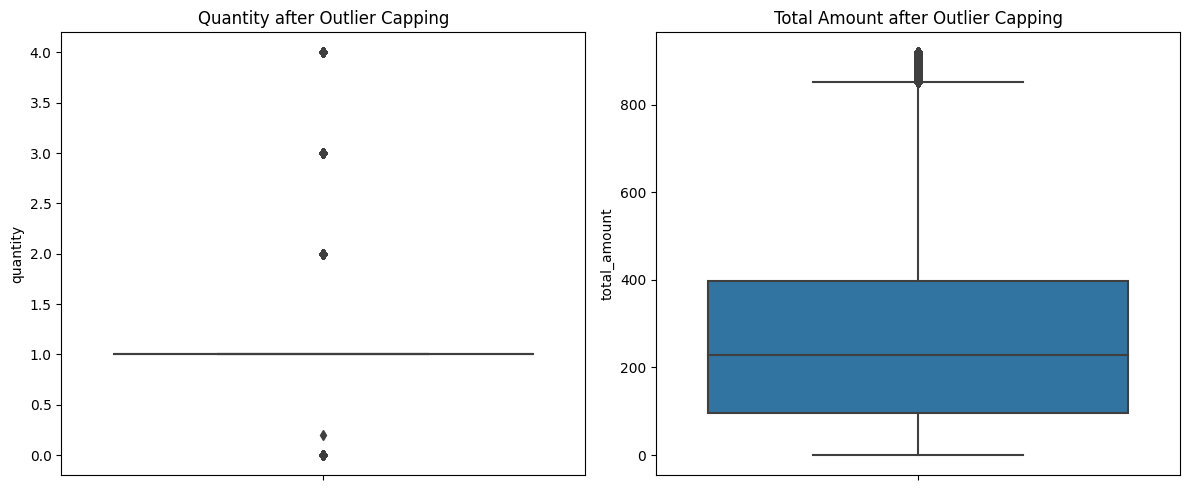

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot after capping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, y='quantity', ax=axes[0])
axes[0].set_title('Quantity after Outlier Capping')

sns.boxplot(data=df, y='total_amount', ax=axes[1])
axes[1].set_title('Total Amount after Outlier Capping')
plt.tight_layout()
plt.show()


# Modeling – Build a Sales Forecasting Model using LSTM/GRU

Step-by-step plan for modeling:
📅 Convert timestamp to datetime format and sort the data.

📊 Aggregate sales at a daily level.

📐 Create sequences of past sales data as features (windowed input).

🧠 Build and train an LSTM or GRU model in TensorFlow/Keras.

🧪 Evaluate using MAPE or RMSE.

📈 Visualize actual vs predicted values.

### Step 2.1: Preprocessing for Time Series
1- Convert timestamp to datetime.

2- Aggregate sales per Hour (total_amount).

In [ ]:

# Step 1: Make sure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Step 2: Floor timestamps to the nearest hour
df['hour'] = df['timestamp'].dt.floor('h')

# Step 3: Group by hour and sum total_amount
hourly_sales = (
    df.groupby('hour', as_index=False)['total_amount']
      .sum()
      .rename(columns={'hour': 'timestamp'})
)

# Step 4: Check result
print(hourly_sales.head())


            timestamp  total_amount
0 2023-10-05 00:00:00    370501.085
1 2023-10-05 01:00:00    122105.654
2 2023-10-05 02:00:00     56513.848
3 2023-10-05 03:00:00     45497.669
4 2023-10-05 04:00:00     41737.068


✅ Done! The sales data is now aggregated at the **hourly** level.

### Step 2.2: Prepare Data for LSTM/GRU Modeling

**To predict the next 30 days of hourly sales for a specific store and product**, we need to:

- Filter the data for the specific store and product.
- Prepare the data:
  - Create sequences (e.g., using the past N hours of data to predict the next hour).
  - Split data into training and test sets.
  - Normalize or scale the data to feed into the neural network.
- Build an LSTM or GRU model in TensorFlow/Keras for time series forecasting.
- Train the model.

**Steps for Preparing the Data**:
1. Create Sequences: For time series forecasting, we use a sliding window approach, where the past N hours of data are used to predict the next hour.
2. Scale Data: It's important to scale the data (e.g., using Min-Max scaling) because neural networks work better with normalized values.
3. Train/Test Split: We will train the model on past data and test it on the last few days to evaluate performance.

To focus on a specific store and product, we can filter the data using the `latitude`, `longitude`, and `product_id` columns

In [ ]:
# Round latitude and longitude to 6 decimal places
df['latitude_rounded'] = df['latitude'].round(6)
df['longitude_rounded'] = df['longitude'].round(6)

# Filter based on rounded values
filtered_data = df[(df['latitude_rounded'] == 23.669917) &
                   (df['longitude_rounded'] == -97.455367) &
                   (df['product_id'] == 1006)]

# Aggregate total_amount at hourly level for the specific store and product
filtered_hourly_sales = (
    filtered_data.assign(hour=pd.to_datetime(filtered_data['timestamp']).dt.floor('h'))
    .groupby('hour', as_index=False)['total_amount']
    .sum()
    .rename(columns={'hour': 'timestamp'})
)

# Display the first few rows of the filtered and aggregated data
print(filtered_hourly_sales.head())


            timestamp  total_amount
0 2023-10-05 00:00:00         84.35
1 2023-10-05 11:00:00         84.35
2 2023-10-05 12:00:00         84.35
3 2023-10-05 13:00:00        312.40
4 2023-10-05 16:00:00         84.35


### Step 2.3: sequence creation and scaling
- Sequence Creation: We need to create sequences of past sales data to predict the next hourly sales.
   - For example, using the past 24 hours (1 day) to predict the sales for the next hour.
- Scaling: Scale the data using Min-Max scaling so that values are in the range [0, 1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Extract the total_amount column
sales_data = filtered_hourly_sales['total_amount'].values.reshape(-1, 1)

# Initialize the MinMaxScaler and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_data)

# Function to create sequences of past sales data (e.g., past 24 hours to predict the next hour)
def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Create sequences for training
sequence_length = 24  # Using 24 hours of past data to predict the next hour
X, y = create_sequences(scaled_sales, sequence_length)

print(X,y)

[[[0.04218766]
  [0.04218766]
  [0.04218766]
  ...
  [0.04218766]
  [0.04218766]
  [0.04218766]]

 [[0.04218766]
  [0.04218766]
  [0.15624687]
  ...
  [0.04218766]
  [0.04218766]
  [0.04218766]]

 [[0.04218766]
  [0.15624687]
  [0.04218766]
  ...
  [0.04218766]
  [0.04218766]
  [0.04218766]]

 ...

 [[0.25312594]
  [0.04218766]
  [0.04218766]
  ...
  [0.08437531]
  [0.08437531]
  [0.16875063]]

 [[0.04218766]
  [0.04218766]
  [0.04218766]
  ...
  [0.08437531]
  [0.16875063]
  [0.04218766]]

 [[0.04218766]
  [0.04218766]
  [0.04218766]
  ...
  [0.16875063]
  [0.04218766]
  [0.08437531]]] [[0.04218766]
 [0.04218766]
 [0.04218766]
 ...
 [0.04218766]
 [0.08437531]
 [0.04218766]]


### Step 2.4: Train-Test Split
We'll split the dataset into training and test sets, with the test set being the most recent data (e.g., the last 30 days).

In [ ]:
# Split into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Display the shape of the training and test data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1621, 24, 1) (1621, 1) (406, 24, 1) (406, 1)


###  Step 2.5: Build the LSTM Model
We'll build 3 model in order to choose top performer:
- LSTM model
- GRU Model
- Bidirectional LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()

# Add LSTM layer (units can be adjusted)
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dense layer for output
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU, Bidirectional

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Attention, LayerNormalization

#  Bidirectional LSTM Model
bidirectional_lstm_model = Sequential()

# First LSTM layer with more neurons
bidirectional_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bidirectional_lstm_model.add(Dropout(0.2))  # Dropout for regularization

# Second LSTM layer with more neurons
bidirectional_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
bidirectional_lstm_model.add(Dropout(0.2))

# Third LSTM layer with more neurons
bidirectional_lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))  # return_sequences=False for the last layer
bidirectional_lstm_model.add(Dropout(0.2))

# Dense layer for output
bidirectional_lstm_model.add(Dense(64, activation='relu'))  # Adding a dense layer with ReLU activation

# Output layer
bidirectional_lstm_model.add(Dense(1))  # Final output layer

# Compile the model
bidirectional_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
bidirectional_lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 24, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 24, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 938,113 (3.58 MB)

 Trainable params: 938,113 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

### Step 2.6: Model Training
We’ll train the model using the training data (X_train, y_train) and evaluate it on the test set (X_test, y_test).

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Display the training and validation loss
print("Training loss:", history.history['loss'][-1])
print("Validation loss:", history.history['val_loss'][-1])

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - val_loss: 0.0075
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0071
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0071
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038 - val_loss: 0.0072
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118
Training loss: 0.003946059383451939
Validation loss: 0.007230781018733978


In [ ]:
gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.0071
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040 - val_loss: 0.0070
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0073


In [ ]:
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 321ms/step - loss: 0.0052 - val_loss: 0.0077
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - loss: 0.0041 - val_loss: 0.0071


### Step 2.7: Evaluate the Model
Loss Evaluation: We'll check the loss values (both training and validation losses) to gauge the 3 model's performance.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


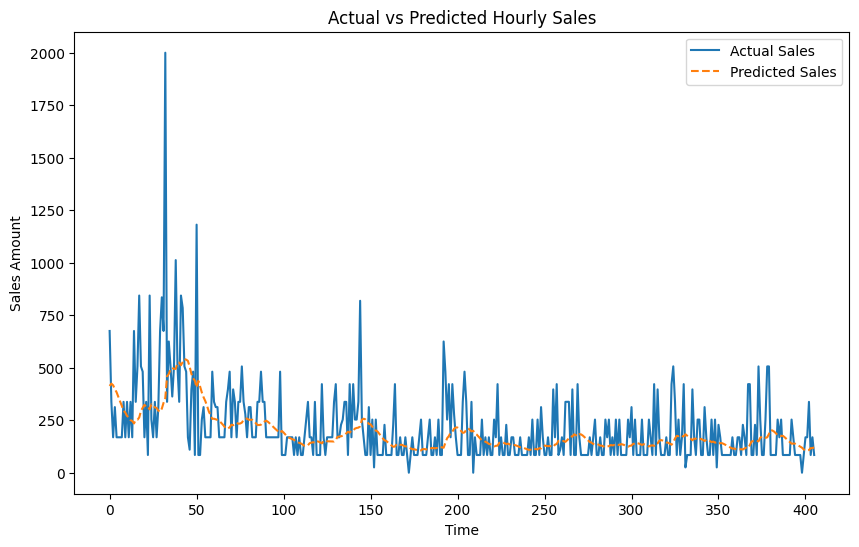

In [ ]:
import matplotlib.pyplot as plt

# 1. For LSTM Model

# Predict the sales for the test set
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and actual values back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', linestyle='--')
plt.title('Actual vs Predicted Hourly Sales')
plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


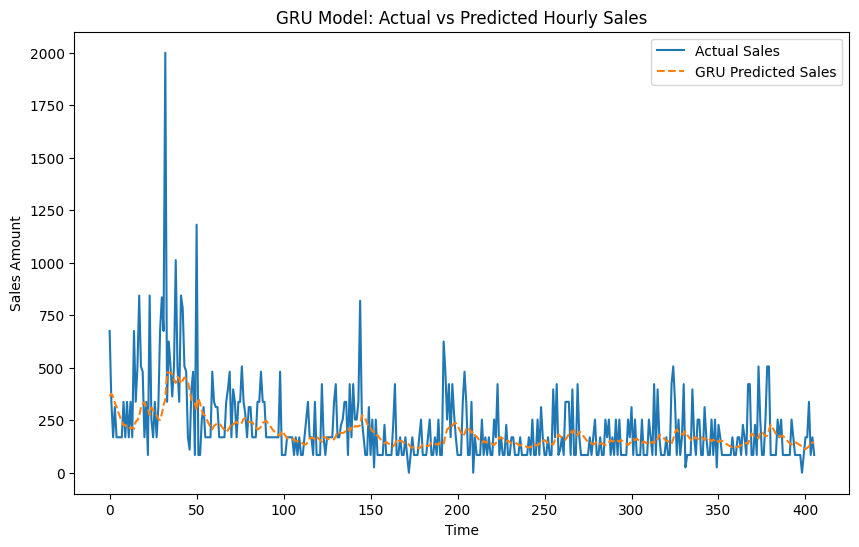

In [ ]:
import matplotlib.pyplot as plt

# 2. For GRU Model
gru_predictions = gru_model.predict(X_test)

# Inverse transform the predictions and actual values back to the original scale
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot Actual vs Predicted sales for GRU Model
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Sales')
plt.plot(gru_predictions, label='GRU Predicted Sales', linestyle='--')
plt.title('GRU Model: Actual vs Predicted Hourly Sales')
plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step


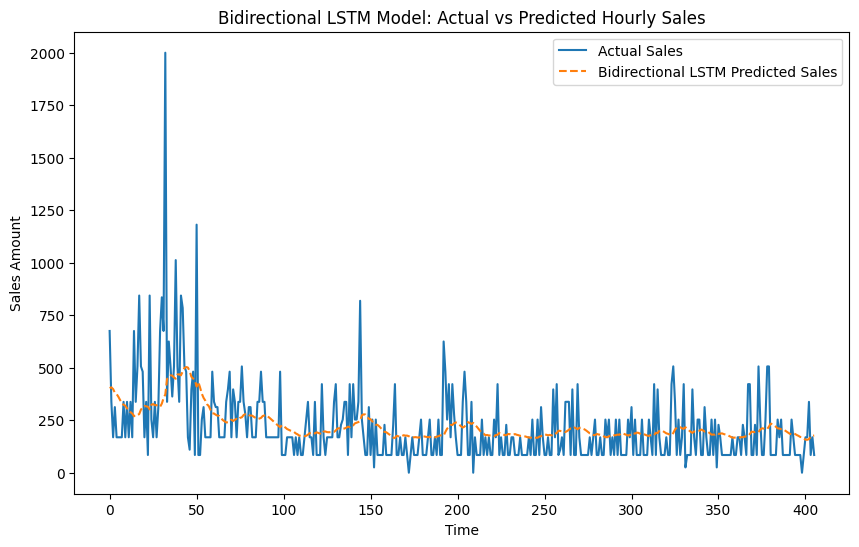

In [ ]:
# 3. For Bidirectional LSTM Model
bidirectional_lstm_predictions = bidirectional_lstm_model.predict(X_test)

# Inverse transform the predictions and actual values back to the original scale
bidirectional_lstm_predictions = scaler.inverse_transform(bidirectional_lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot Actual vs Predicted sales for Bidirectional LSTM Model
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Sales')
plt.plot(bidirectional_lstm_predictions, label='Bidirectional LSTM Predicted Sales', linestyle='--')
plt.title('Bidirectional LSTM Model: Actual vs Predicted Hourly Sales')
plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


### Step 2.8: Predictions and Visualization

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# 1. For LSTM Model
# Compute MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test_actual, predictions)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

# print("LSTM MAPE:", mape)
print("LSTM RMSE:", rmse)


LSTM RMSE: 170.0169780371245


In [ ]:
# 2. For GRU Model

# Calculate MAPE and RMSE for GRU Model
gru_mape = mean_absolute_percentage_error(y_test_actual, gru_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))

# print(f"GRU Model MAPE: {gru_mape}")
print(f"GRU Model RMSE: {gru_rmse}")


GRU Model RMSE: 169.21620050042006


In [ ]:
# 3. For Bidirectional LSTM Model

# Calculate MAPE and RMSE for Bidirectional LSTM Model
bidirectional_lstm_mape = mean_absolute_percentage_error(y_test_actual, bidirectional_lstm_predictions)
bidirectional_lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, bidirectional_lstm_predictions))

# print(f"Bidirectional LSTM Model MAPE: {bidirectional_lstm_mape}")
print(f"Bidirectional LSTM Model RMSE: {bidirectional_lstm_rmse}")


Bidirectional LSTM Model RMSE: 168.29858918987856


- Bidirectional LSTM has the lowest RMSE (168.29), meaning it's the best model in terms of RMSE.

- GRU comes second with an RMSE of 169.22.

- LSTM has the highest RMSE (170.02), which means it's the least accurate model among the three based on this metric.